# Amazon Food Review - Sentiment Analysis

#### This is a dataset from Amazon for more than 500k rows of food reviews. We will implement sentiment analysis to check if the food review is positive or not. 

###### FInal Result to predict - Review is positive or negative

#### Steps to follow:
1. Text Preprocessing and Cleaning
2. Data Exploration
3. Feature Extraction
4. Data Modeling

##### Evaluation metric: F1-Score

##### Importing Libraries

In [56]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os


pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [57]:
#import os
#os.chdir('AmazonFoodReview')

In [58]:
df = pd.read_csv('Reviews.csv')

In [59]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."


In [60]:
# Checking Null values
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

We have 16 null profile names and 27 null Summary. We can drop these as the number of null rows is comparitively very low compared to the number of total data we have(~500k). 

In [61]:
# Dropping the null values
df.dropna(axis=0, inplace=True)

In [62]:
df['Helpfulness'] = ""

In [63]:
df["Upvote_Factor_percent"] = ""

In [64]:
# Columns
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpfulness', 'Upvote_Factor_percent'],
      dtype='object')

In [65]:
# Creating a column to calculate Helpfulness
df.loc[df['HelpfulnessDenominator']>0, 'Helpfulness'] = df.HelpfulnessNumerator/df.HelpfulnessDenominator
df.loc[df['HelpfulnessDenominator']<=0, 'Helpfulness'] = -1
df['Upvote_Factor_percent'] = pd.cut(df['Helpfulness'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest=True)

In [66]:
# Score vs Upvote_Factor_percent

Score_upvote = pd.crosstab(df['Score'], df['Upvote_Factor_percent'])

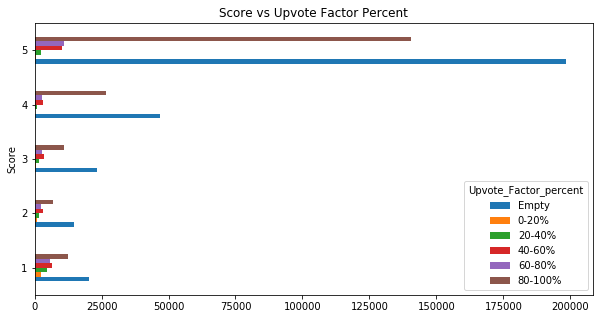

In [67]:
Score_upvote.plot(kind = 'barh', title = 'Score vs Upvote Factor Percent',figsize=(10,5))

In [68]:
print(Score_upvote)

Upvote_Factor_percent   Empty  0-20%  20-40%  40-60%  60-80%  80-100%
Score                                                                
1                       20324   2338    4649    6586    5836    12531
2                       14837    737    1618    3051    2486     7014
3                       23484    474    1506    3384    2754    11036
4                       46796    116     909    3185    2941    26707
5                      198372    432    2275   10312   11060   140659


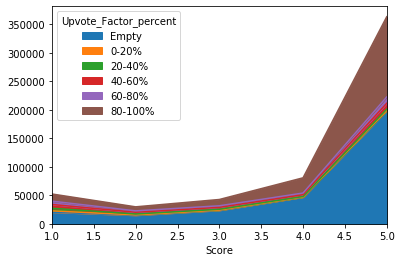

In [69]:
Score_upvote.plot(kind='area')

In [70]:
# Most of the votes are empty in all ranges (specifically in 4-5 score range)

In [71]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpfulness', 'Upvote_Factor_percent'],
      dtype='object')

In [72]:
# We can get rid of the neutral reviews, as they don't tell any sentiment
df_new = df[df['Score']!=3]
x = df_new.Text
dict_map = {1:0, 2:0, 4:1, 5:1}
y = df_new.Score.map(dict_map)

In [73]:
df_review = pd.DataFrame(data=list(zip(x,y)), columns = ['Text','Label'])

In [74]:
# Snapshot of the final dataframe 
df_review.head(5)

,Text,Label
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,1
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",0
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",1
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,0
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",1


In [75]:
# Checking the count of labels
df_review.Label.value_counts()

# Label 0 is only 15% of the whole dataset, hence we can say that the dataset is imbalanced. 

1    443766
0     82007
Name: Label, dtype: int64

In [76]:
# Let's have a look at the length of the reviews to see if there is any pattern between bad and good reviews. 

good = df_review.Text.str.len()
bad = df_review.Text.str.len()

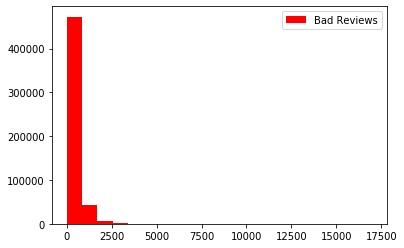

In [77]:
plt.hist(bad, bins = 20, label = 'Bad Reviews', color='red')
plt.legend()
plt.show()

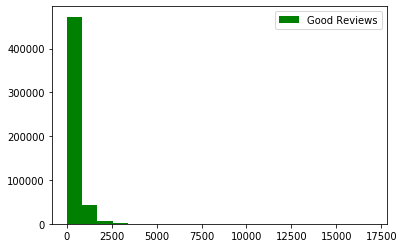

In [78]:
plt.hist(good, bins = 20, label = 'Good Reviews', color='green')
plt.legend()
plt.show()

In [79]:
# No observable pattern between the lengths of a bad review and good review. 

###### In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.

In [80]:
# Snapshot
df_review.Text.iloc[0:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [81]:
# Removing all the punctution, special characters and numbers
df_review.Text = df_review.Text.str.replace("[^a-zA-Z]", " ")

In [82]:
# Snapshot
df_review.Text.iloc[0:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality  The product looks more like a stew than a processed meat and it smells better  My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts   the peanuts were actually small sized unsalted  Not sure if this was an error or if the vendor intended to represent the product as  Jumbo  
2    This is a confection that has been around a few centuries   It is a light  pillowy citrus gelatin with nuts   in this case Filberts  And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it   I got this in addition to the Root Beer Extract I ordered  which was good  and made some cherry soda   The fl...
4                                                               Great taffy at a great price   There was a wide assortment of yummy taffy   Delivery was very quick   If your a taff

In [83]:
import nltk

In [84]:
import os

In [85]:
# Removing stop words

import nltk
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))


In [86]:
df_review['new_text'] = df_review['Text'].apply(lambda x: ' '.join([i for i in x.split() if i not in sw]))
df_review['new_text'] = df_review['new_text'].apply(lambda x: x.lower())

In [89]:
# Word Normalisation - Stemming
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
#df_review['tokenized'] = ""
df_review['tokenized'] = (df_review['new_text'].apply(lambda x: x.split())).apply(lambda a: [stemmer.stem(i) for i in a])

In [95]:
df_review['tokenized'] = df_review['tokenized'].apply(lambda x: ' '.join([i for i in x]))

In [90]:
df_review

,Text,Label,new_text,tokenized
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality The product looks more like a stew than a processed meat and it smells better My Labr...,1,i bought several vitality canned dog food products found good quality the product looks like stew processed meat smells better my labrador finicky appreciates product better,"[i, bought, sever, vital, can, dog, food, product, found, good, qualiti, the, product, look, like, stew, process, meat, smell, better, my, labrador, finicki, appreci, product, better]"
1,Product arrived labeled as Jumbo Salted Peanuts the peanuts were actually small sized unsalted Not sure if this was an error or if the vendor intended to represent the product as Jumbo,0,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted not sure error vendor intended represent product jumbo,"[product, arriv, label, jumbo, salt, peanut, peanut, actual, small, size, unsalt, not, sure, error, vendor, intend, repres, product, jumbo]"
2,This is a confection that has been around a few centuries It is a light pillowy citrus gelatin with nuts in this case Filberts And it is cut into tiny squares and then liberally coated with ...,1,this confection around centuries it light pillowy citrus gelatin nuts case filberts and cut tiny squares liberally coated powdered sugar and tiny mouthful heaven not chewy flavorful i highly recom...,"[thi, confect, around, centuri, it, light, pillowi, citru, gelatin, nut, case, filbert, and, cut, tini, squar, liber, coat, powder, sugar, and, tini, mouth, heaven, not, chewi, flavor, i, highli, ..."
3,If you are looking for the secret ingredient in Robitussin I believe I have found it I got this in addition to the Root Beer Extract I ordered which was good and made some cherry soda The fl...,0,if looking secret ingredient robitussin i believe i found i got addition root beer extract i ordered good made cherry soda the flavor medicinal,"[if, look, secret, ingredi, robitussin, i, believ, i, found, i, got, addit, root, beer, extract, i, order, good, made, cherri, soda, the, flavor, medicin]"
4,Great taffy at a great price There was a wide assortment of yummy taffy Delivery was very quick If your a taffy lover this is a deal,1,great taffy great price there wide assortment yummy taffy delivery quick if taffy lover deal,"[great, taffi, great, price, there, wide, assort, yummi, taffi, deliveri, quick, if, taffi, lover, deal]"
...,...,...,...,...
525768,Great for sesame chicken this is a good if not better than resturants I have eaten at My husband loved it will find other recipes to use this in,1,great sesame chicken good better resturants i eaten my husband loved find recipes use,"[great, sesam, chicken, good, better, restur, i, eaten, my, husband, love, find, recip, use]"
525769,I m disappointed with the flavor The chocolate notes are especially weak Milk thickens it but the flavor still disappoints This was worth a try but I ll never buy again I will use what s left ...,0,i disappointed flavor the chocolate notes especially weak milk thickens flavor still disappoints this worth try i never buy i use left gone time thanks small cans,"[i, disappoint, flavor, the, chocol, note, especi, weak, milk, thicken, flavor, still, disappoint, thi, worth, tri, i, never, buy, i, use, left, gone, time, thank, small, can]"
525770,These stars are small so you can give of those in one training session I tried to train our dog with Ceaser dog treats it just made our puppy hyper If you compare the ingredients y...,1,these stars small give one training session i tried train dog ceaser dog treats made puppy hyper if compare ingredients know little stars basic food ingredients without preservatives food coloring...,"[these, star, small, give, one, train, session, i, tri, train, dog, ceaser, dog, treat, made, puppi, hyper, if, compar, ingredi, know, littl, star, basic, food, ingredi, without, preserv, food, co..."
525771

In [245]:
#df_review['tokenized'] = df_review['new_text']

#### Story Generation and Visualisation

###### Answering the following questions:
1. What are the most common words in the entire dataset?
2. What are the most common words in the dataset for negative and positive tweets, respectively?

In [146]:
#!pip install wordcloud

     |████████████████████████████████| 163kB 2.4MB/s eta 0:00:01


In [96]:
from wordcloud import WordCloud

In [97]:
all_words = ' '.join([txt for txt in df_review.tokenized])

In [98]:
wc = WordCloud(width = 800, height = 500, background_color='white', max_words=100, random_state=37). generate(all_words)

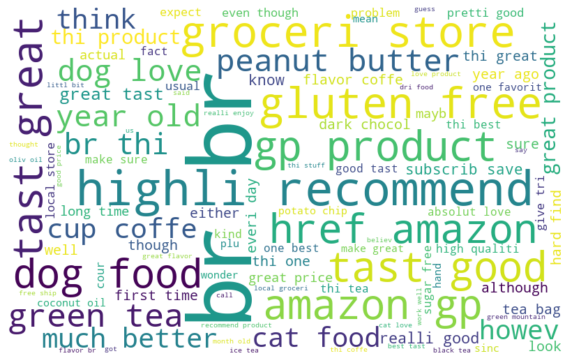

In [99]:
plt.figure(figsize=(10, 7)) 
plt.imshow(wc, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [100]:
df_review.columns

Index(['Text', 'Label', 'new_text', 'tokenized'], dtype='object')

In [105]:
positive = df_review[df_review['Label']==1]

In [110]:
all_positive_words = ' '.join([txt for txt in positive.tokenized])

In [112]:
positive_wc = WordCloud(width = 800, height = 500, background_color='white', max_words=100, random_state=37). generate(all_positive_words)

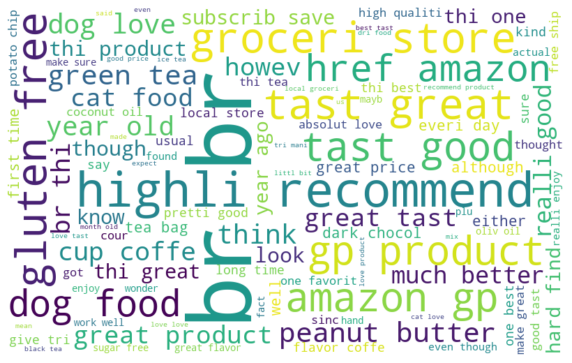

In [113]:
plt.figure(figsize=(10, 7)) 
plt.imshow(positive_wc, interpolation="bilinear") 
plt.axis('off') 
plt.show()

#### Negative words

In [116]:
negative = df_review[df_review['Label']==0]

In [117]:
all_negative_words = ' '.join([txt for txt in negative.tokenized])

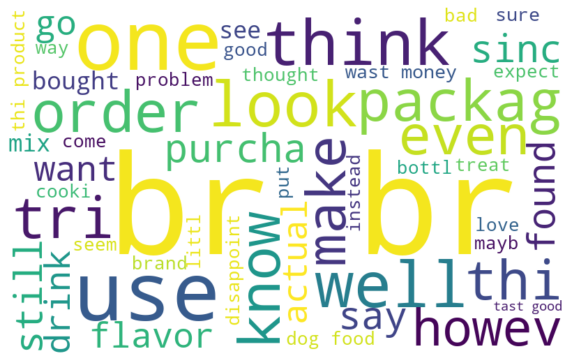

In [118]:
negative_wc = WordCloud(width = 800, height = 500, background_color='white', max_words=50, random_state=37). generate(all_negative_words)
plt.figure(figsize=(10, 7)) 
plt.imshow(negative_wc, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### Feature extraction

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

##### Bag-of-words vectorizer

In [128]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df_review['tokenized'])

In [129]:
bow.shape

(525773, 1000)

###### tf-idf vectorizer

In [130]:
tfidf_vec = TfidfVectorizer(max_df=0.90, min_df = 2, max_features=1000, stop_words = 'english')

In [131]:
tfidf = tfidf_vec.fit_transform(df_review['tokenized'])

In [133]:
tfidf.shape

(525773, 1000)